# Analyze variability QTL

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
from pybedtools import BedTool
import statsmodels.formula.api as smf
import statsmodels.api as sm
import imp
pd.set_option('display.max_columns', 100)
import os
import pickle as pkl
%matplotlib inline
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'slategrey', 'silver'])


In [2]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
import encode
import memento
import run_memento

In [3]:
data_path  = '/data_volume/memento/lupus/'

### Read variability eqtl results

In [4]:
vqtls = []
all_tests = []
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        df = pd.read_csv(data_path + 'full_analysis/memento/100kb/{}_{}_variability.csv'.format(pop, ct))
        
        # Get gene means
        adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
        means = adata.X.mean(axis=0).A1
        mean_df = pd.DataFrame()
        mean_df['gene'] = adata.var.index.tolist()
        mean_df['mean'] = means
        
        df['pop'] = pop
        df['ct'] = ct
        df = df.merge(mean_df, on='gene', how='left')
        
        if df.query('dv_fdr < 0.1').shape[0] > 0:
            vqtls.append(df.query('dv_fdr < 0.1'))
        all_tests.append(df)
vqtls = pd.concat(vqtls)
all_tests = pd.concat(all_tests)

In [5]:
pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)

In [6]:
min_counts = pos.apply(lambda x: pd.value_counts(x).iloc[-1], axis=1).reset_index(name='min_count')


KeyboardInterrupt



In [ ]:
all_tests = all_tests.merge(min_counts, left_on='tx', right_on='CHROM:POS', how='left').query('min_count > 5')

In [ ]:
vqtls = vqtls.merge(min_counts, left_on='tx', right_on='CHROM:POS', how='left').query('min_count > 5')

In [7]:
vqtls.to_csv(data_path + '../tables/Supplementary_Table_6_SLE_vQTL.csv', index=False)

In [11]:
vqtls.head(5)

,tx,gene,dv_coef,de_coef,de_pval,de_fdr,dv_pval,dv_fdr,pop,ct,mean
11827,1:182289775,GLUL,-0.392056,-0.147294,1.608030e-02,1.925673e-01,1.534213e-05,0.034515,asian,T4,0.038377
12678,1:204528344,MDM4,-0.308246,-0.217337,2.710719e-19,1.856638e-16,5.987290e-07,0.006421,asian,T4,0.188055
12679,1:204512195,MDM4,-0.308246,-0.217337,2.710719e-19,1.856638e-16,5.987290e-07,0.006421,asian,T4,0.188055
12685,1:204450467,MDM4,-0.318024,-0.233575,2.027968e-13,9.306747e-11,4.330888e-05,0.060539,asian,T4,0.188055
12687,1:204549496,MDM4,-0.291286,-0.212146,1.247821e-18,7.994322e-16,1.538555e-06,0.010082,asian,T4,0.188055


In [12]:
vqtls[['gene', 'tx']].drop_duplicates().shape

(10607, 2)

In [9]:
vqtls.gene.drop_duplicates().shape

(733,)

### Q-Q plot

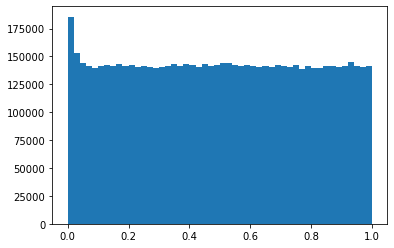

In [9]:
plt.hist(all_tests['dv_pval'], bins=50);

In [11]:
num_tests = all_tests.shape[0]

In [12]:
unif_quantiles = stats.uniform.ppf(np.linspace(0, 1, num_tests))

In [13]:
sorted_pvs = np.sort(all_tests.dv_pval)

/tmp/ipykernel_6269/1690487092.py:1: RuntimeWarning: divide by zero encountered in log10
  plt.scatter(-np.log10(unif_quantiles), -np.log10(sorted_pvs))


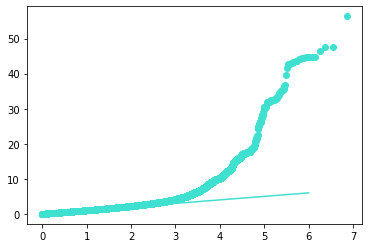

In [14]:
plt.scatter(-np.log10(unif_quantiles), -np.log10(sorted_pvs))
plt.plot([0, 6], [0, 6])

### Explore

In [ ]:
vqtls.sort_values('dv_coef')\
    .drop_duplicates('gene')\
    .sort_values('mean', ascending=False).head(30)

### Make plots

In [ ]:
for pop in ['asian', 'eur']:
    
    pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)

    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        
        adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
        donor_counts = adata.obs['ind_cov'].value_counts()
        filter_condition = adata.obs.ind_cov.isin(pos.columns) & adata.obs.ind_cov.isin(donor_counts[donor_counts > 100].index)
        adata = adata[filter_condition].copy()
        adata.obs['capture_rate'] = 0.1
        memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.05)
        memento.create_groups(adata, label_columns=['ind_cov'])

        memento.compute_1d_moments(adata, min_perc_group=.2)
        moments = memento.get_1d_moments(adata)[0].set_index('gene')

        moments.columns = [x[3:] for x in moments.columns]

        to_plot = vqtls.query('pop == "{}" & ct == "{}"'.format(pop, ct))\
            .sort_values('dv_coef')\
            .drop_duplicates('gene')\
            .query('mean > 5')
        
        if to_plot.shape[0] == 0:
            continue
        for idx, row in to_plot.iterrows():

            SNP = row['tx']
            gene = row['gene']
            beta = row['dv_coef']

            info = pd.concat([pos.loc[SNP], moments.loc[gene]], axis=1).dropna()
            info.columns=[SNP, 'variability']

            plt.figure(figsize=(10,2))
            plt.subplot(1, 4, 1)

            sns.boxplot(x=SNP, y='variability', data=info, color='gray')
            sns.stripplot(x=SNP, y='variability', data=info, color='black', s=3)
            plt.ylabel('{} Variability'.format(gene))

            # plt.savefig('{}_{}_{}_{}_{}_box.pdf'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight')

            new_obs = adata.obs.merge(
                info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
                on='ind_cov', how='left')
            new_obs.index=adata.obs.index

            vals0 = get_expr(info[info['variability']==info[info[SNP]==0]['variability'].quantile(interpolation='nearest')].index[0], gene)
            vals1 = get_expr(info[info['variability']==info[info[SNP]==1]['variability'].quantile(interpolation='nearest')].index[0], gene)
            vals2 = get_expr(info[info['variability']==info[info[SNP]==2]['variability'].quantile(interpolation='nearest')].index[0], gene)

            max_val = np.max([vals0.max(), vals1.max(), vals2.max()])

        #     plt.figure(figsize=(6.5,2))
            plt.subplots_adjust(wspace=0.3)
            plt.subplot(1,4,2)
            plt.hist(vals0, density=True, bins=20)
            plt.xlim(0, max_val)

            plt.subplot(1,4,3)
            plt.hist(vals1, density=True, bins=20)
            plt.xlim(0, max_val)


            plt.subplot(1,4,4)
            plt.hist(vals2, density=True, bins=20)
            plt.xlim(0, max_val)
            
            plt.savefig('variability_figures/{}_{}_{}_{}.png'.format(pop, ct, gene, SNP), bbox_inches='tight', dpi=200)

### Choose an example

- asian ncM 1:26597673 CD52
- asian NK 2:85929674 GNLY
- eur ncM 6:31326612 HLA-C


In [16]:
pop = 'eur'
ct = 'ncM'

In [24]:
adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
donor_counts = adata.obs['ind_cov'].value_counts()
filter_condition = adata.obs.ind_cov.isin(pos.columns) & adata.obs.ind_cov.isin(donor_counts[donor_counts > 100].index)
adata = adata[filter_condition].copy()
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.05)
memento.create_groups(adata, label_columns=['ind_cov'])

memento.compute_1d_moments(adata, min_perc_group=.2, gene_list=['HLA-C'])
moments = memento.get_1d_moments(adata)[0].set_index('gene')

moments.columns = [x[3:] for x in moments.columns]


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [44]:
def get_expr(ind, gene):
    
    return adata[adata.obs.ind_cov==ind, gene].X.todense().A1+1

In [45]:
to_plot = vqtls.query('pop == "{}" & ct == "{}"'.format(pop, ct))\
    .sort_values('dv_coef')\
    .drop_duplicates('gene')\
    .sort_values('mean', ascending=False).head(2)

In [46]:
# for idx, row in to_plot.iterrows():

# SNP = row['tx']
# gene = row['gene']
# beta = row['dv_coef']

# info = pd.concat([pos.loc[SNP], moments.loc[gene]], axis=1).dropna()
# info.columns=[SNP, 'variability']

# plt.figure(figsize=(10,2))
# plt.subplot(1, 4, 1)

# sns.boxplot(x=SNP, y='variability', data=info, color='gray')
# sns.stripplot(x=SNP, y='variability', data=info, color='black', s=3)
# plt.ylabel('{} Variability'.format(gene))

# # plt.savefig('{}_{}_{}_{}_{}_box.pdf'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight')

# new_obs = adata.obs.merge(
#     info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
#     on='ind_cov', how='left')
# new_obs.index=adata.obs.index

# vals0 = get_expr(info[info['variability']==info[info[SNP]==0]['variability'].quantile(interpolation='nearest')].index[0], gene)
# vals1 = get_expr(info[info['variability']==info[info[SNP]==1]['variability'].quantile(interpolation='nearest')].index[0], gene)
# vals2 = get_expr(info[info['variability']==info[info[SNP]==2]['variability'].quantile(interpolation='nearest')].index[0], gene)

# max_val = np.max([vals0.max(), vals1.max(), vals2.max()])

# #     plt.figure(figsize=(6.5,2))
# plt.subplots_adjust(wspace=0.3)
# plt.subplot(1,4,2)
# plt.hist(vals0, density=True, bins=20)
# plt.xlim(0, max_val)

# plt.subplot(1,4,3)
# plt.hist(vals1, density=True, bins=20)
# plt.xlim(0, max_val)


# plt.subplot(1,4,4)
# plt.hist(vals2, density=True, bins=20)
# plt.xlim(0, max_val)



### Pick one example

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


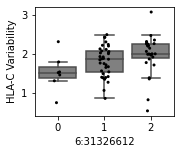

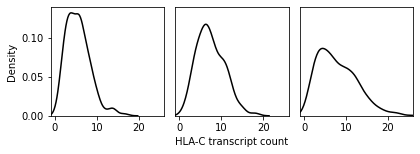

In [71]:

SNP = '6:31326612'
gene = 'HLA-C'

info = pd.concat([pos.loc[SNP], moments.loc[gene]], axis=1).dropna()
info.columns=[SNP, 'variability']

plt.figure(figsize=(2.5,2))
# plt.subplot(1, 4, 1)

sns.boxplot(x=SNP, y='variability', data=info, color='gray', fliersize=0)
sns.stripplot(x=SNP, y='variability', data=info, color='black', s=3)
plt.ylabel('{} Variability'.format(gene))

plt.savefig('{}_{}_{}_{}_box.pdf'.format(pop, ct, gene, SNP), bbox_inches='tight')

new_obs = adata.obs.merge(
    info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
    on='ind_cov', how='left')
new_obs.index=adata.obs.index

vals0 = get_expr(info[info['variability']==info[info[SNP]==0]['variability'].quantile(interpolation='nearest')].index[0], gene)
vals1 = get_expr(info[info['variability']==info[info[SNP]==1]['variability'].quantile(interpolation='nearest')].index[0], gene)
vals2 = get_expr(info[info['variability']==info[info[SNP]==2]['variability'].quantile(interpolation='nearest')].index[0], gene)

max_val = np.max([vals0.max(), vals1.max(), vals2.max()])

plt.figure(figsize=(6.5,2))
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,3,1)
# plt.hist(vals0, density=True, bins=25)
sns.kdeplot(vals0, color='black')
plt.ylim(0, 0.14)
plt.xlim(-1, max_val)

plt.subplot(1,3,2)
# plt.hist(vals1, density=True, bins=25)
sns.kdeplot(vals1, color='black')
plt.yticks([]);plt.ylabel(None)
plt.xlabel('HLA-C transcript count')
plt.xlim(-1, max_val)
plt.ylim(0, 0.14)


plt.subplot(1,3,3)
# plt.hist(vals2, density=True, bins=25)
sns.kdeplot(vals2, color='black')
plt.yticks([]);plt.ylabel(None)
plt.xlim(-1, max_val)
plt.ylim(0, 0.14)

plt.savefig('{}_{}_{}_{}_histo.pdf'.format(pop, ct, gene, SNP), bbox_inches='tight', dpi=300)


### Read eqtl results

In [5]:
eqtls = []
for pop in ['asian', 'eur']:
    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        df = pd.read_csv(data_path + 'full_analysis/memento/100kb/{}_{}.csv'.format(pop, ct))\
			.query('FDR < 0.01 & (beta < -0.1 | beta > 0.1)')\
			.rename(columns={'gene':'gene_2', 'SNP':'tx'})[['tx', 'gene_2', 'beta']].copy()
        df['pop'] = pop
        df['ct'] = ct
        eqtls.append(df)
eqtls = pd.concat(eqtls)

### Merge the results

In [6]:
qtls = cqtls.merge(eqtls, on=['tx', 'gene_2', 'pop', 'ct'], how='left')

### Get ENCODE information

In [36]:
snp_locs = qtls.tx.drop_duplicates().tolist()

In [85]:
snp_site_windows = pd.DataFrame()
snp_site_windows['chrom'] = ['chr'+a.split(':')[0] for a in snp_locs]
snp_site_windows['txStart'] = [int(a.split(':')[1])-1 for a in snp_locs]
snp_site_windows['txEnd'] = [int(a.split(':')[1])+1 for a in snp_locs]
snp_site_windows['name'] = snp_locs

In [86]:
tfs = qtls['gene_1'].drop_duplicates().tolist()

In [87]:
encode_meta = pd.read_csv('../../cd4_cropseq/encode_tf/metadata.tsv', sep='\t', header=0)
encode_files = pd.read_csv('../../cd4_cropseq/encode_tf/files.txt', sep='\t', header=None)

encode_meta = encode_meta[encode_meta['Output type'].isin([ 'IDR thresholded peaks', 'optimal IDR thresholded peaks']) & (encode_meta['File assembly'] == 'GRCh38')]
encode_meta['target'] = encode_meta['Experiment target'].str.split('-').str[0]
encode_meta = encode_meta.sort_values('Output type', ascending=False).drop_duplicates('target').query('target in @tfs')
encode_meta = encode_meta[encode_meta['Audit ERROR'].isnull()]

In [ ]:
imp.reload(encode)
enc = encode.Encode('/home/ssm-user/Github/misc-seq/miscseq/GRCh38Genes.bed')
encode_result = {}

for idx, row in encode_meta.iterrows():
    
    url = row['File download URL']
    genes = enc.get_peak_sites_encode(url, snp_site_windows)
    encode_result[row['target']] = genes.query('distance >= 0').copy()

In [89]:
encode_df = []
for k, v in encode_result.items():
    
    v['tf'] = k
    encode_df.append(v)
encode_df = pd.concat(encode_df)
encode_df.columns=['tx', 'distance', 'gene_1']
encode_df.to_csv(data_path + 'encode_result.csv', index=False)

### Merge ENCODE informatoin

In [7]:
encode_df = pd.read_csv(data_path + 'encode_result.csv')

In [8]:
qtls = qtls.merge(encode_df, on=['tx', 'gene_1'], how='left')#.sort_values('distance')

### Plot some QTLs

In [9]:
cqtl_pairs = list(set([(a,b) for a,b in zip(qtls['gene_1'], qtls['gene_2'])]))
all_pair_genes = list(set(qtls['gene_1']) | set(qtls['gene_2']))

In [16]:
def get_expr(condition, gene):
    
    return np.log(adata[condition, gene].X.todense().A1+1)

asian T4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


asian cM


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

asian ncM


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

asian T8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

asian B


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


asian NK


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


asian T4


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


asian cM


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

asian ncM


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

asian T8


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWa

asian B


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


asian NK


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


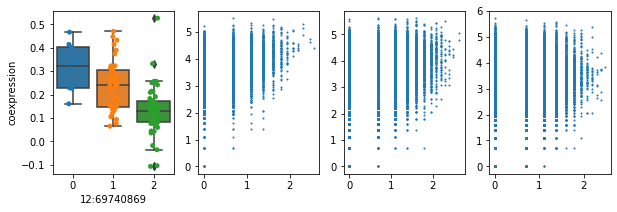

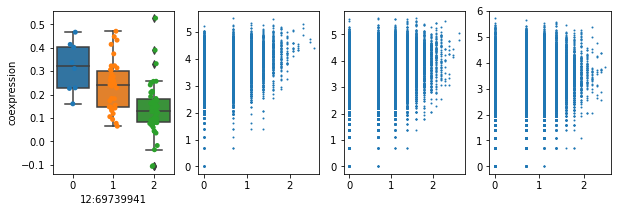

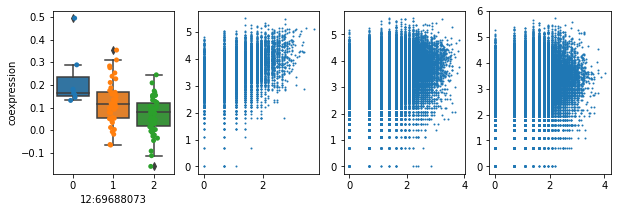

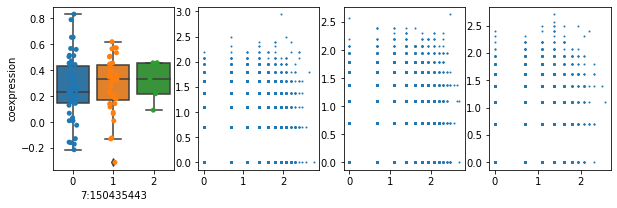

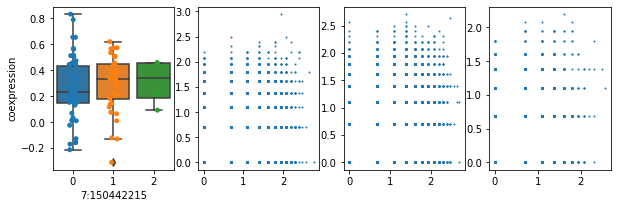

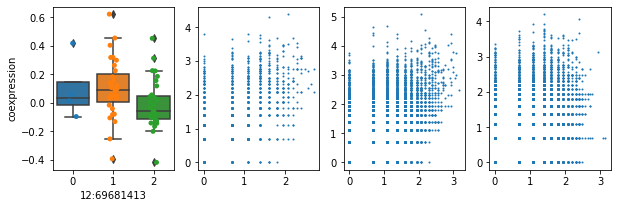

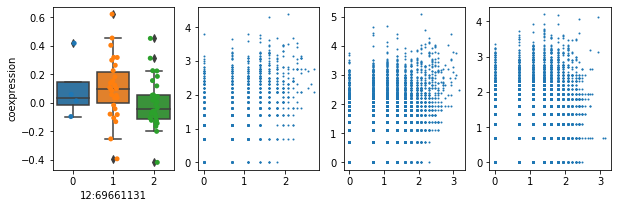

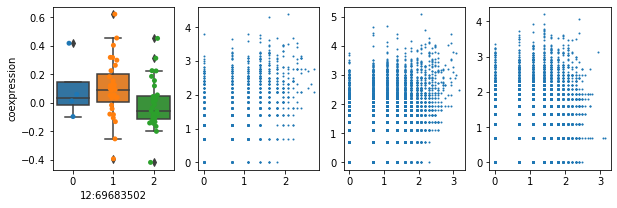

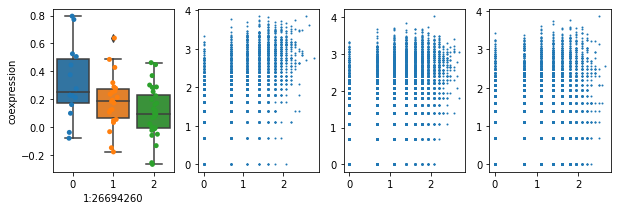

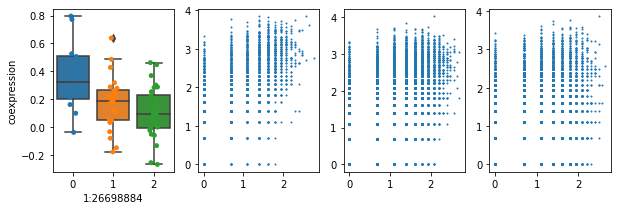

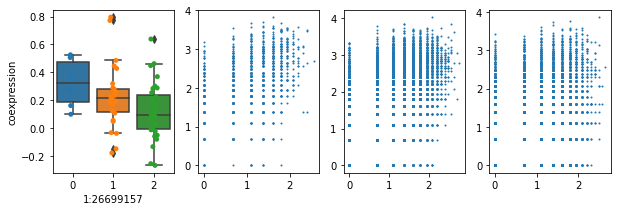

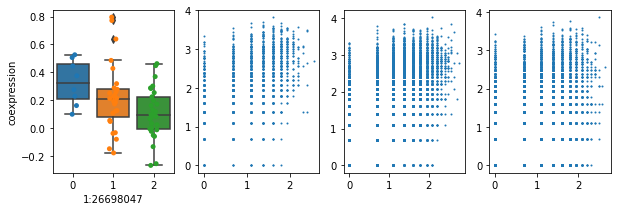

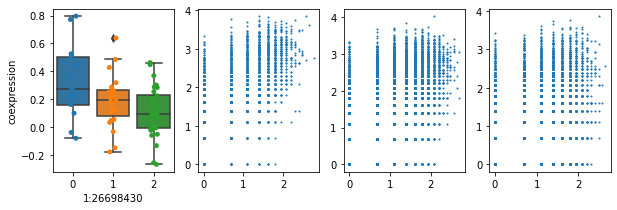

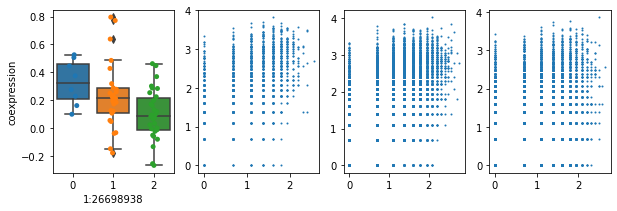

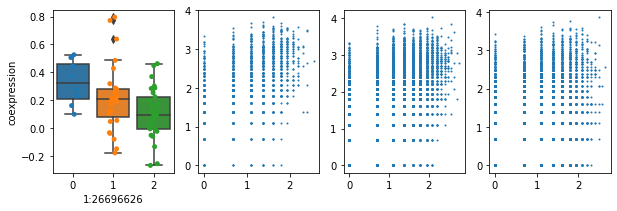

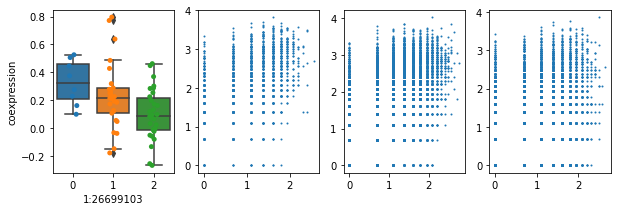

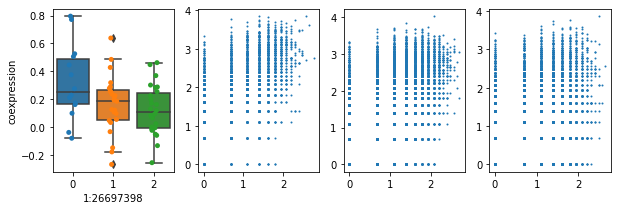

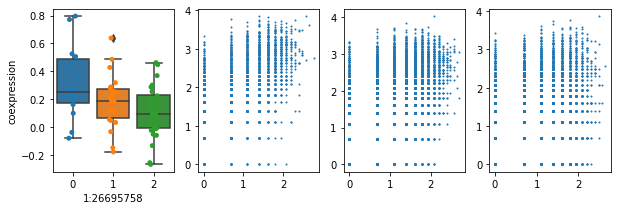

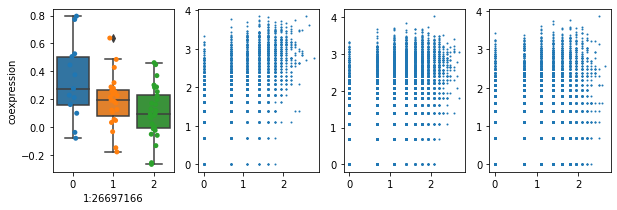

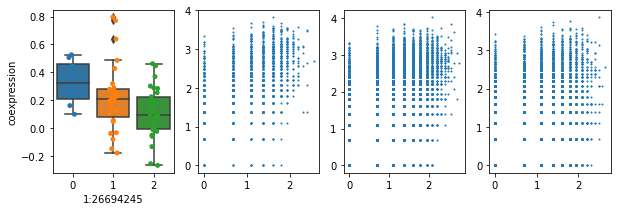

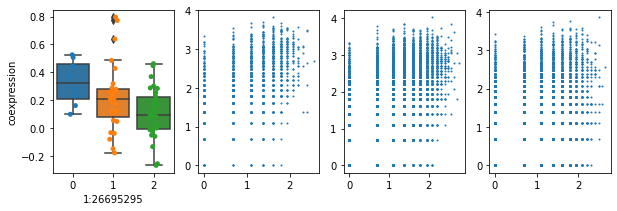

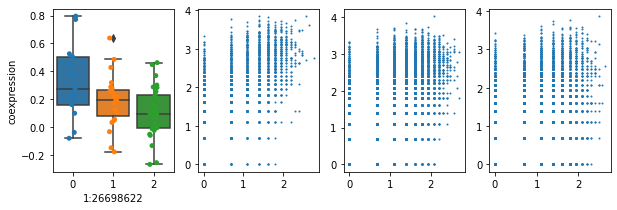

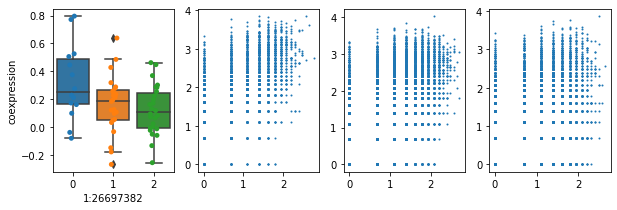

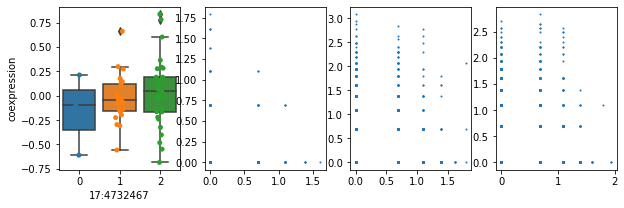

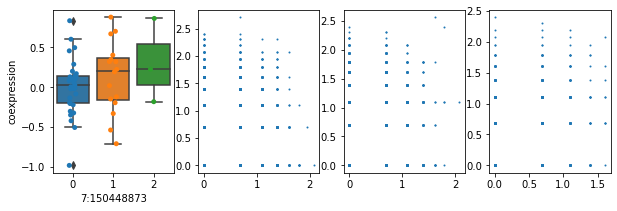

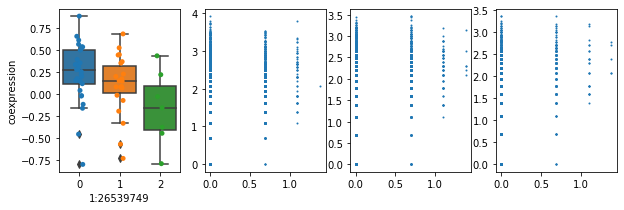

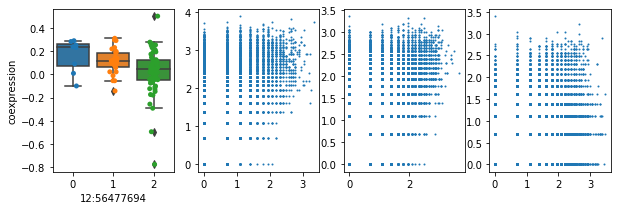

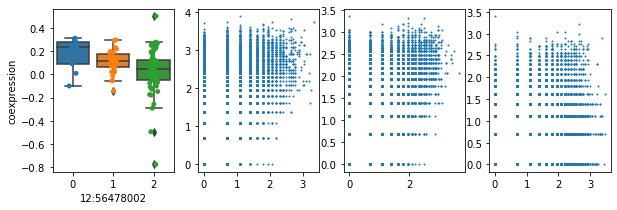

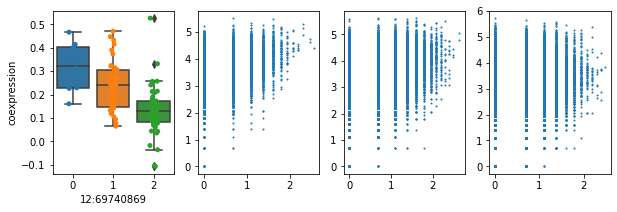

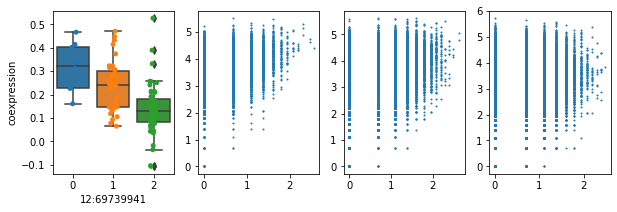

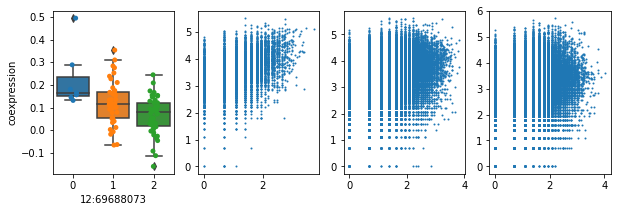

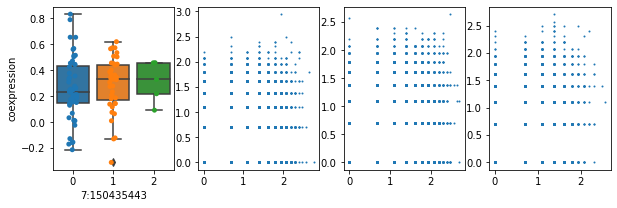

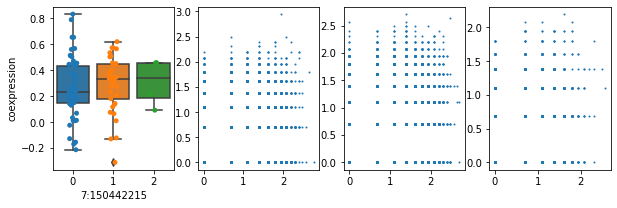

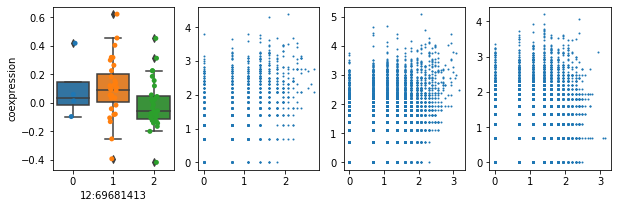

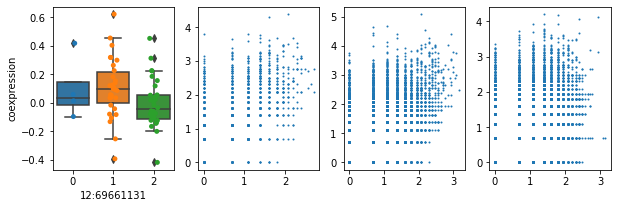

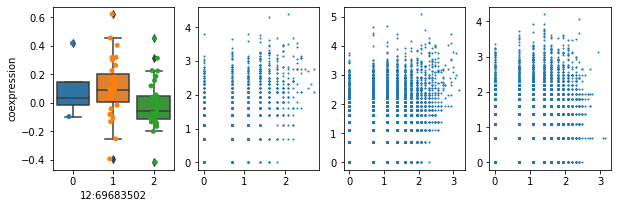

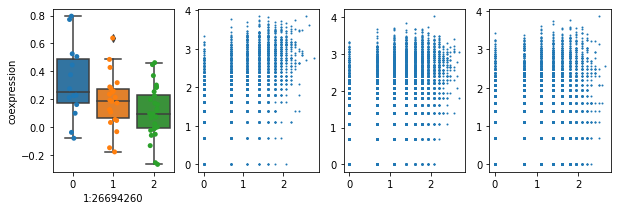

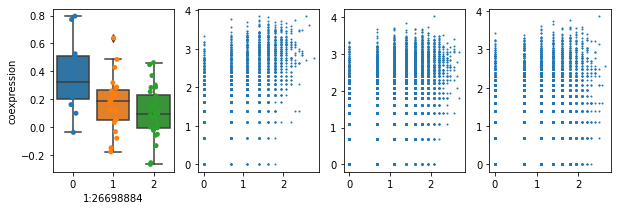

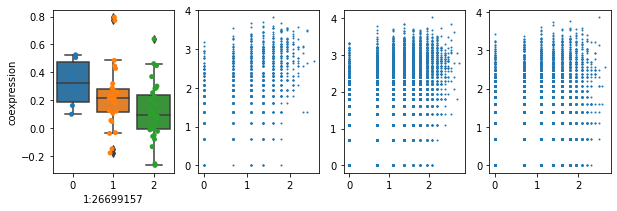

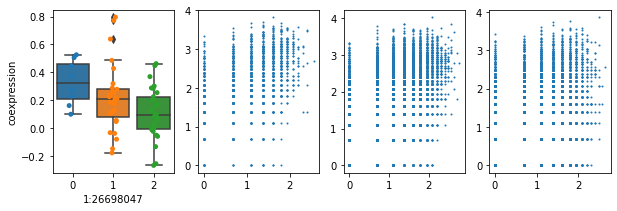

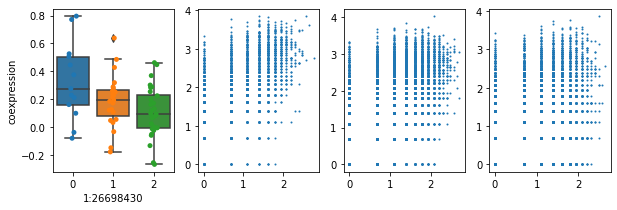

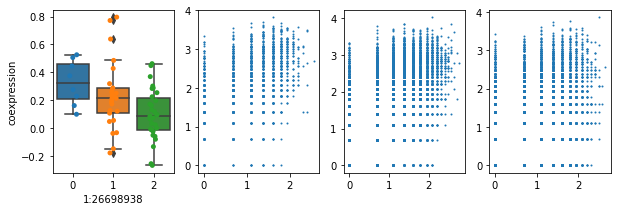

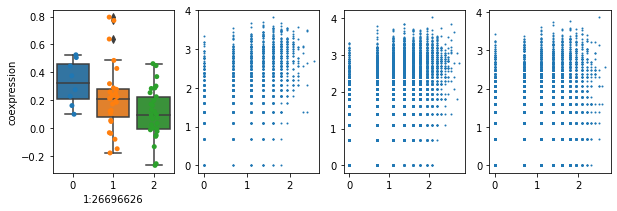

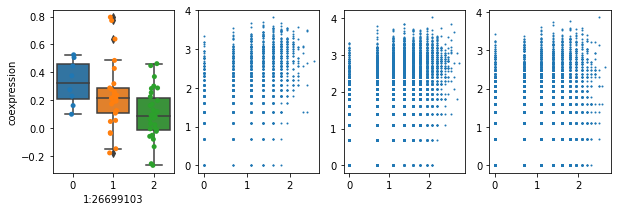

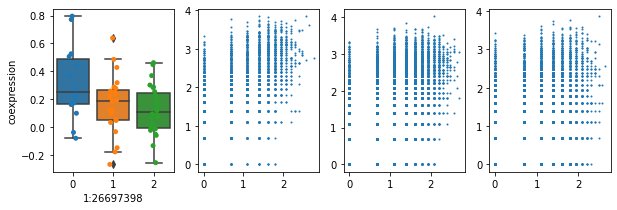

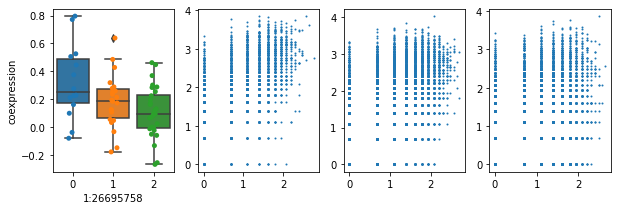

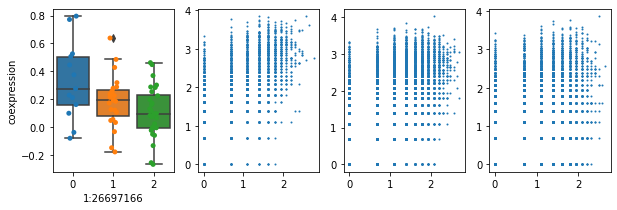

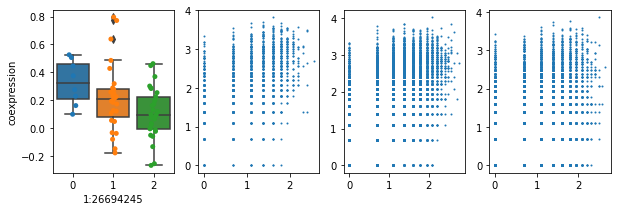

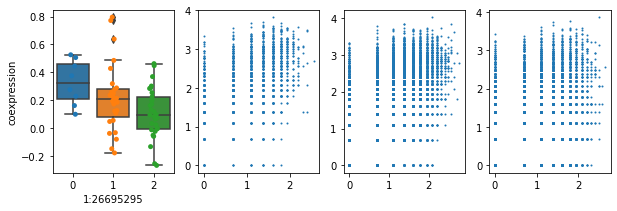

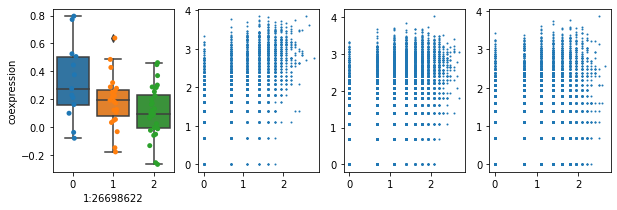

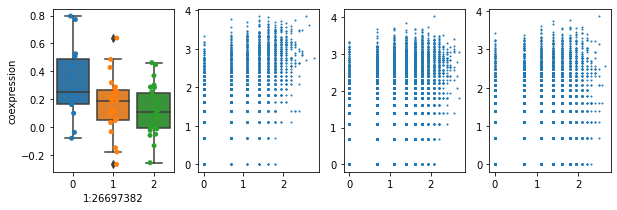

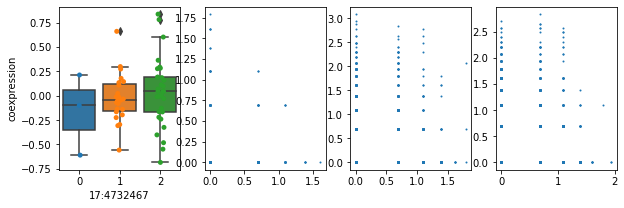

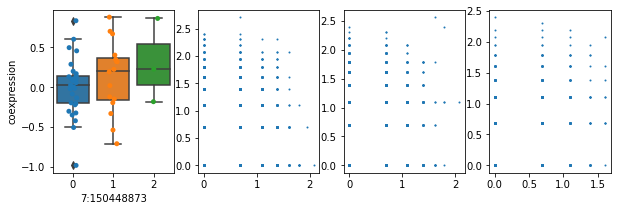

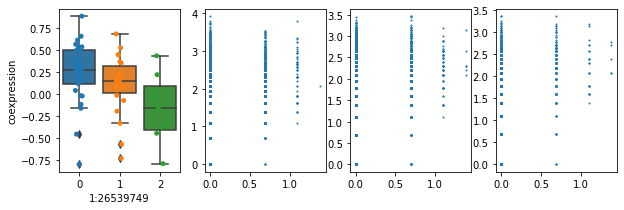

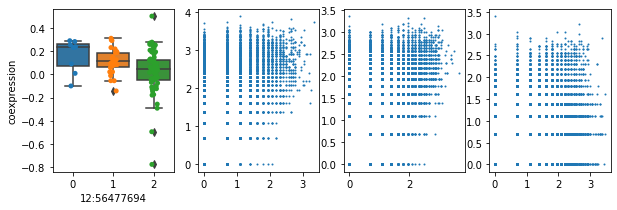

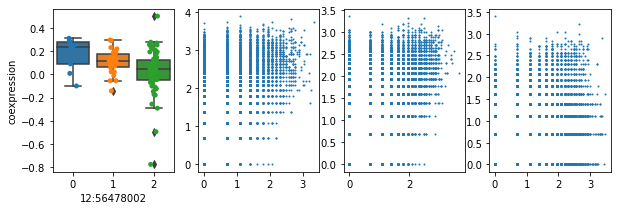

In [18]:
for pop in ['asian', 'eur']:
    
    pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)

    for ct in ['T4', 'cM', 'ncM', 'T8', 'B', 'NK']:
        
        print(pop, ct)
        
        adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
        donor_counts = adata.obs['ind_cov'].value_counts()
        filter_condition = adata.obs.ind_cov.isin(pos.columns) & adata.obs.ind_cov.isin(donor_counts[donor_counts > 100].index)
        adata = adata[filter_condition].copy()
        adata.obs['capture_rate'] = 0.1
        memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.07)
        memento.create_groups(adata, label_columns=['ind_cov'])

        memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=all_pair_genes)
        memento.compute_2d_moments(adata, [(a,b) for a,b in cqtl_pairs if a in adata.var.index and b in adata.var.index])
        
        moments = memento.get_2d_moments(adata)[0].set_index(['gene_1', 'gene_2'])
        moments.columns = [x[3:] for x in moments.columns]
        
        to_plot = qtls.query('distance <1000 & (corr_coef*beta)>0 & ct == "{}" & pop == "{}"'.format(ct, pop))
        
        if to_plot.shape[0] == 0:
            continue
        
        for idx, row in to_plot.iterrows():
    
            gene_1, gene_2, SNP = row['gene_1'], row['gene_2'], row['tx']
            
            info = pd.concat([pos.loc[SNP], moments.loc[gene_1, gene_2]], axis=1).dropna()
            info.columns=[SNP, 'coexpression']
            info = info.query('coexpression < 1 & coexpression > -1')

            plt.figure(figsize=(10,3))
            plt.subplot(1,4,1)
            sns.boxplot(x=SNP, y='coexpression', data=info)
            sns.stripplot(x=SNP, y='coexpression', data=info)

            new_obs = adata.obs.merge(
                info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
                on='ind_cov', how='left')
            new_obs.index=adata.obs.index

            plt.subplot(1,4,2)
            plt.scatter(
                get_expr(new_obs['geno'] == 0, gene_1), 
                get_expr(new_obs['geno'] == 0, gene_2), s=1)

            plt.subplot(1,4,3)
            plt.scatter(
                get_expr(new_obs['geno'] == 1, gene_1), 
                get_expr(new_obs['geno'] == 1, gene_2), s=1)

            plt.subplot(1,4,4)
            plt.scatter(
                get_expr(new_obs['geno'] == 2, gene_1), 
                get_expr(new_obs['geno'] == 2, gene_2), s=1)
            plt.savefig('figures/{}_{}_{}_{}_{}.png'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches=False)

### Choose an example - JUND LYZ

In [95]:
SNP = '12:69688073'
gene_1 = 'JUNB'
gene_2 = 'LYZ'
pop = 'asian'
ct = 'cM'

In [96]:
pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)

In [97]:
adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
donor_counts = adata.obs['ind_cov'].value_counts()
filter_condition = adata.obs.ind_cov.isin(pos.columns) & adata.obs.ind_cov.isin(donor_counts[donor_counts > 100].index)
adata = adata[filter_condition].copy()
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.07)
memento.create_groups(adata, label_columns=['ind_cov'])

memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=all_pair_genes)
memento.compute_2d_moments(adata, [(a,b) for a,b in cqtl_pairs if a in adata.var.index and b in adata.var.index])

moments = memento.get_2d_moments(adata)[0].set_index(['gene_1', 'gene_2'])
moments.columns = [x[3:] for x in moments.columns]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


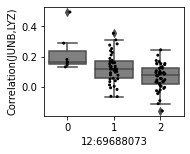

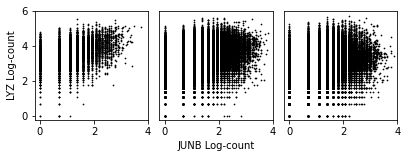

In [98]:
info = pd.concat([pos.loc[SNP], moments.loc[gene_1, gene_2]], axis=1).dropna()
info.columns=[SNP, 'coexpression']
info = info.query('coexpression < 1 & coexpression > -1')

plt.figure(figsize=(2.5,2))

sns.boxplot(x=SNP, y='coexpression', data=info, color='gray')
sns.stripplot(x=SNP, y='coexpression', data=info, color='black', s=3)
plt.ylabel('Correlation({},{})'.format(gene_1, gene_2))

plt.savefig('{}_{}_{}_{}_{}_box.pdf'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight')

new_obs = adata.obs.merge(
    info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
    on='ind_cov', how='left')
new_obs.index=adata.obs.index

plt.figure(figsize=(6.5,2))
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,3,1)
plt.scatter(
    get_expr(new_obs['geno'] == 0, gene_1), 
    get_expr(new_obs['geno'] == 0, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.ylabel('{} Log-count'.format(gene_2))

plt.subplot(1,3,2)
plt.scatter(
    get_expr(new_obs['geno'] == 1, gene_1), 
    get_expr(new_obs['geno'] == 1, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 4)
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.xlabel('{} Log-count'.format(gene_1))
plt.yticks([])

plt.subplot(1,3,3)
plt.scatter(
    get_expr(new_obs['geno'] == 2, gene_1), 
    get_expr(new_obs['geno'] == 2, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 4)
plt.xlim(-0.2, 4); plt.ylim(-0.2, 6)
plt.yticks([])
plt.savefig('{}_{}_{}_{}_{}_scatter.png'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight', dpi=300)

### Choose an example - CEPBD LYZ

In [99]:
SNP = '12:69740869'
gene_1 = 'CEBPD'
gene_2 = 'LYZ'
pop = 'asian'
ct = 'cM'

In [100]:
pos = pd.read_csv(data_path + 'mateqtl_input/{}_genos.tsv'.format(pop), sep='\t', index_col=0)

In [101]:
adata = sc.read(data_path + 'single_cell/{}_{}.h5ad'.format(pop, ct))
donor_counts = adata.obs['ind_cov'].value_counts()
filter_condition = adata.obs.ind_cov.isin(pos.columns) & adata.obs.ind_cov.isin(donor_counts[donor_counts > 100].index)
adata = adata[filter_condition].copy()
adata.obs['capture_rate'] = 0.1
memento.setup_memento(adata, q_column='capture_rate', trim_percent=0.1, filter_mean_thresh=0.07)
memento.create_groups(adata, label_columns=['ind_cov'])

memento.compute_1d_moments(adata, min_perc_group=.5, gene_list=all_pair_genes)
memento.compute_2d_moments(adata, [(a,b) for a,b in cqtl_pairs if a in adata.var.index and b in adata.var.index])

moments = memento.get_2d_moments(adata)[0].set_index(['gene_1', 'gene_2'])
moments.columns = [x[3:] for x in moments.columns]

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


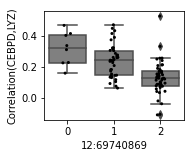

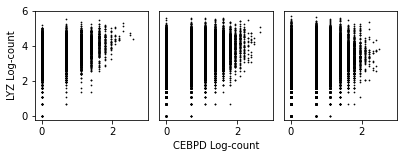

In [102]:
info = pd.concat([pos.loc[SNP], moments.loc[gene_1, gene_2]], axis=1).dropna()
info.columns=[SNP, 'coexpression']
info = info.query('coexpression < 1 & coexpression > -1')

plt.figure(figsize=(2.5,2))

sns.boxplot(x=SNP, y='coexpression', data=info, color='gray')
sns.stripplot(x=SNP, y='coexpression', data=info, color='black', s=3)
plt.ylabel('Correlation({},{})'.format(gene_1, gene_2))

plt.savefig('{}_{}_{}_{}_{}_box.pdf'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight')

new_obs = adata.obs.merge(
    info[SNP].reset_index(name='geno').rename(columns={'index':'ind_cov'}),\
    on='ind_cov', how='left')
new_obs.index=adata.obs.index

plt.figure(figsize=(6.5,2))
plt.subplots_adjust(wspace=0.1)
plt.subplot(1,3,1)
plt.scatter(
    get_expr(new_obs['geno'] == 0, gene_1), 
    get_expr(new_obs['geno'] == 0, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 3); plt.ylim(-0.2, 6)
plt.ylabel('{} Log-count'.format(gene_2))

plt.subplot(1,3,2)
plt.scatter(
    get_expr(new_obs['geno'] == 1, gene_1), 
    get_expr(new_obs['geno'] == 1, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 3); plt.ylim(-0.2, 6)
plt.xlabel('{} Log-count'.format(gene_1))
plt.yticks([])

plt.subplot(1,3,3)
plt.scatter(
    get_expr(new_obs['geno'] == 2, gene_1), 
    get_expr(new_obs['geno'] == 2, gene_2), s=0.5, color='black')
plt.xlim(-0.2, 3); plt.ylim(-0.2, 6)
plt.yticks([])
plt.savefig('{}_{}_{}_{}_{}_scatter.png'.format(pop, ct, gene_1, gene_2, SNP), bbox_inches='tight', dpi=300)

In [103]:
to_plot = qtls.query('distance ==0 & (corr_coef*beta)>0')

In [104]:
to_plot

,gene_1,gene_2,tx,corr_coef,corr_se,corr_pval,corr_fdr,statistic,pop,ct,beta,distance
850,SPI1,TMEM176B,7:150435443,0.147797,0.037970,0.000103,0.050430,3.892474,asian,cM,0.158933,0.0
1653,DRAP1,CD52,1:26698430,-0.164368,0.033612,0.000003,0.015824,-4.890130,asian,ncM,-0.265891,0.0
1678,DRAP1,CD52,1:26695758,-0.166921,0.033718,0.000003,0.013925,-4.950500,asian,ncM,-0.256660,0.0
2371,XRCC5,TMEM176B,7:150448873,0.722535,0.117389,0.000073,0.076932,6.155075,asian,ncM,0.250768,0.0
